# Protein constraints enable prediction of dynamic substrate uptake hierarchy

## dFBA
$$
\begin{align}
\max_v  \quad & \mu=c^T v \\
\mathrm{s.t.} \quad & Sv = 0 \\
& l(t) \leq v \leq u(t) \\
\end{align}
$$

$$
\begin{align}
\frac{dc_i}{dt} &= s_i v^{\mathrm{ex}}_i  X \\
\frac{dX}{dt}   &= \mu X
\end{align}
$$

$$
\begin{align}
v^{max}_i \leq \frac{c_i(t)}{X \Delta t}
\end{align}
$$

$$
\begin{align}
l_i(t) \geq -\frac{c_i(t)}{X \Delta t}
\end{align}
$$

## Load base M model

In [1]:
from cobra.io import load_json_model

model = load_json_model('data/iJO1366.json')
model.reactions.EX_o2_e.lower_bound = -20
model.optimize()

<Solution 0.98 at 0x7f5b4af7ce10>

# 1. Load data for validation
### Use model to convert metabolites from mol/L to g/L

In [2]:
import pandas as pd
df_meas_mol = pd.read_csv('data/beg_measured_me47.csv')  # mol/L

In [3]:
cols_met = [c for c in df_meas_mol.columns if c not in ['time','biomass']]
# Convert to g/L
df_meas = df_meas_mol.copy()
for col in cols_met:
    mw = model.metabolites.get_by_id(col).formula_weight
    df_meas[col] = df_meas[col] * mw / 1000.

In [4]:
df_meas_melt = pd.melt(df_meas, id_vars='time')
df_meas_melt['met'] = df_meas_melt['variable']
df_meas_melt.head()

,time,variable,value,met
0,0.0,glc__D_e,0.40,glc__D_e
1,0.5,glc__D_e,0.39,glc__D_e
2,1.0,glc__D_e,0.36,glc__D_e
3,1.5,glc__D_e,0.31,glc__D_e
4,2.0,glc__D_e,0.26,glc__D_e


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#660066', # acetate
        '#00FF00', # galactose
        '#000000', # glucose
        '#FF00FF', # glycerol
        '#0000FF', # lactate
        '#FF0000' # maltose
        ]

palette = sns.palettes.color_palette(colors)

def plot_dynamic(df_sim, df_meas=None):
    if df_meas is None:
        dsplot = df_sim[ df_sim.variable != 'biomass']
    else:
        df1 = df_meas
        df1.loc[:,'source'] = 'Measured'
        df2 = df_sim
        df2.loc[:,'source'] = 'Simulated'
        dsplot = pd.concat([df1,df2])
    dsplot.loc[:,'variable'] = dsplot.variable.astype('category')
    dsplot.variable.cat.reorder_categories(['ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
    sns.set_palette(palette)
    if df_meas is None:
        g = sns.FacetGrid(dsplot, hue='variable', size=6)        
    else:
        #d = {'ls':['-','--']}
        g = sns.FacetGrid(dsplot, hue='variable', col='source', size=6)
        
    g.map(plt.plot, 'time','value')
    g.set_xlabels('Time (h)')
    g.set_ylabels('Concentration (g/L)')
    g.add_legend()
    
    return g

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:537 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


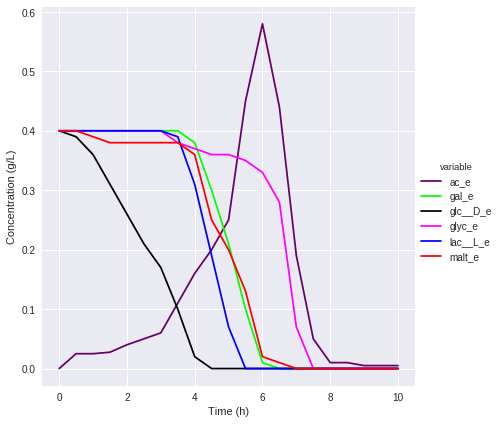

In [6]:
%matplotlib inline
g = plot_dynamic(df_meas_melt)

In [7]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/beg_meas.pdf')
# g.savefig('figures/beg_meas.svg')
# g.savefig('figures/beg_meas.eps')
# g.savefig('figures/beg_meas.png',dpi=500)

# 2. Create the protein-constrained FBA model

In [8]:
from cobra import Metabolite, Reaction

class Constraint(Metabolite):
    pass

class Variable(Reaction):
    pass

df_mws = pd.read_csv('data/ijomm_protmass_simple_mws_R02.csv')
ProtM = df_mws.mmol_gDW.sum()
ProtGrams = df_mws.g_gDW.sum()

import numpy as np

### Start from fresh M model
pcfba = load_json_model('data/iJO1366.json')

### Define some nominal turnover.
### Assume same for all enzymes for now.
KEFF_SCALE = 0.8
KEFF_BASAL = 65. * KEFF_SCALE

### Add crowding constraint:
cons_crowding = Constraint('crowding')
cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtGrams

pcfba.add_metabolites([cons_crowding])

### Track nominal keff dict for sensitivity analysis later
coeff_dict = {}

for rid in df_mws.bigg_id.unique():
    dfi = df_mws[ df_mws.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    kDa = dfi['kDa'].mean()
    rxn = pcfba.reactions.get_by_id(rid)    
    keff = KEFF_BASAL
    coeff = 1./keff/3600 * kDa
    ### If rxn is reversible, need to split into positive parts
    ### so that crowding constraint applies to only positive fluxes
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        pcfba.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Constraint('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Constraint('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})        
        rxn_abs.add_metabolites({cons_crowding:coeff })
        coeff_dict[rxn_abs.id] = coeff
    else:
        rxn.add_metabolites({cons_crowding:coeff})
        coeff_dict[rxn.id] = coeff

In [9]:
tracked_mets = [c for c in df_meas.columns if c not in ['time','biomass']]
met_rxn_dict = {met_id:'EX_%s'%met_id for met_id in tracked_mets}

# Unconstrain uptakes
for rid in met_rxn_dict.values():
    rxn = pcfba.reactions.get_by_id(rid)
    rxn.lower_bound = -1000
    
# Except oxygen--diffusion
pcfba.reactions.EX_o2_e.lower_bound = -20

rxn_mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'

In [10]:
X0 = df_meas.iloc[0]['biomass'] # Initial biomass
V  = 1 # Volume in L
T  = 10
dt = 0.1

In [11]:
mdl = pcfba

# 3. General dFBA code (minimal implementation)

In [12]:
from six import iteritems

In [13]:
def dFBA(mdl, X0, conc_dict0, met_rxn_dict, mu_id, T, dt=0.1, o2_rxn='EX_o2_e',vmaxi = 1000):
    # 1) Initialize concentrations
    conc_dict = dict(conc_dict0)
    tracked_mets = conc_dict.keys()
    rxn_mu = mdl.reactions.get_by_id(mu_id)

    t = 0
    X = X0    # Biomass gDW/L
    
    row0 = dict(conc_dict)
    row0['t'] = t
    row0['X'] = X
    row0['mu'] = 0.
    rows = [row0]
    
    v_rows = []
    while t < T:
        # 1) check boundary conditions
        for met_id, rxn_id in iteritems(met_rxn_dict):
            rxn = mdl.reactions.get_by_id(rxn_id)
            xi  = conc_dict[met_id]
            # Uptakes are negative, so max instead of min
            if xi <= 0:
                vup = 0;
            else:
                vup = max(-xi/X/dt, -vmaxi)
            rxn.lower_bound = vup
            
        # 2) optimize
        mdl.optimize()
        if mdl.solution is not None and mdl.solution.status == 'optimal':
            x_dict = mdl.solution.x_dict
        else:
            x_dict = {rxn.id:0. for rxn in mdl.reactions}
        
        # 3) Update macroscopic variables
        row = {}        
        mu = x_dict[mu_id]
        X_new = X + mu*X*dt
        v_row = {}
        for met_id,rxn_id in iteritems(met_rxn_dict):
            v_exi = x_dict[rxn_id]
            v_row[rxn_id] = v_exi
            x_new = rows[-1][met_id] + X*v_exi*dt  # mmol/L
            #x_new = conc_dict[met_id] + X*v_exi*dt   # mmol/L
            x_new = max(0, x_new)
            row[met_id] = x_new            
        
        v_row[o2_rxn] = x_dict[o2_rxn]  # Track o2
        
        conc_dict = {k:v for k,v in iteritems(row) if k in tracked_mets}
        X = X_new        
        t += dt        
        row['X'] = X_new
        row['t'] = t    
        row['mu'] = mu
        rows.append(row)
        v_row['t'] = t
        v_rows.append(v_row)
        
    df_sim = pd.DataFrame(rows)
    df_flux= pd.DataFrame(v_rows)
    return df_sim, df_flux

# 4. Simulate with protein constraints

In [14]:
conc_dict_mol = df_meas_mol[cols_met].iloc[0].to_dict()
df_result, df_flux = dFBA(pcfba, X0, conc_dict_mol, met_rxn_dict, rxn_mu_id, 10)

In [15]:
# Convert to g/L
df_sim = df_result.copy()
for col in cols_met:
    mw = model.metabolites.get_by_id(col).formula_weight
    df_sim[col] = df_sim[col] * mw / 1000.

In [16]:
df_sim.rename(columns={'t':'time','X':'biomass'}, inplace=True)
dsplot = df_sim[['time']+cols_met].melt(id_vars='time')

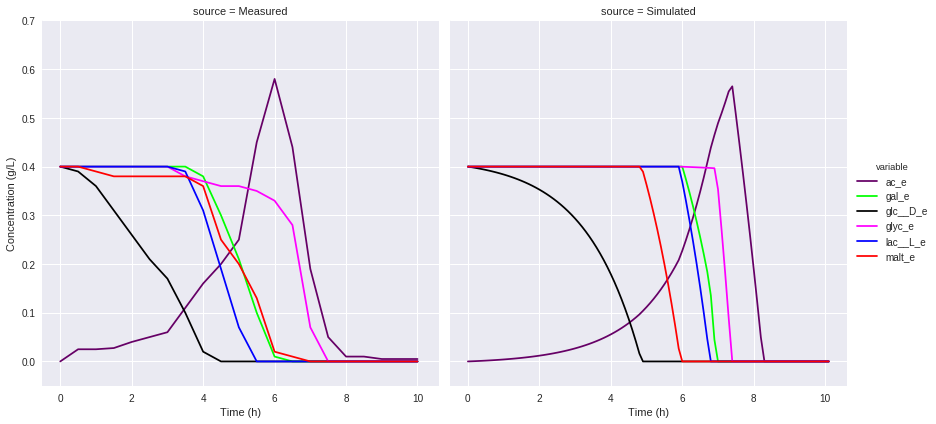

In [17]:
%matplotlib inline
dsplot_meas = df_meas_melt[df_meas_melt.variable.isin(cols_met)].sort_values('time')
g = plot_dynamic(dsplot, dsplot_meas)
g.set(ylim=[-0.05, 0.7])

In [18]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/beg_pcfba_val.pdf')
# g.savefig('figures/beg_pcfba_val.svg')
# g.savefig('figures/beg_pcfba_val.eps')
# g.savefig('figures/beg_pcfba_val.png',dpi=500)

# 5. Simulate without proteome constraints

In [19]:
df_result_fba, df_flux_fba = dFBA(model, X0, conc_dict_mol, met_rxn_dict, rxn_mu_id, 10, vmaxi=10)

# Convert to g/L
df_sim_fba = df_result_fba.copy()
for col in cols_met:
    mw = model.metabolites.get_by_id(col).formula_weight
    df_sim_fba[col] = df_sim_fba[col] * mw / 1000.
df_sim_fba.rename(columns={'t':'time','X':'biomass'}, inplace=True)
dsplot_fba = df_sim_fba[['time']+cols_met].melt(id_vars='time')

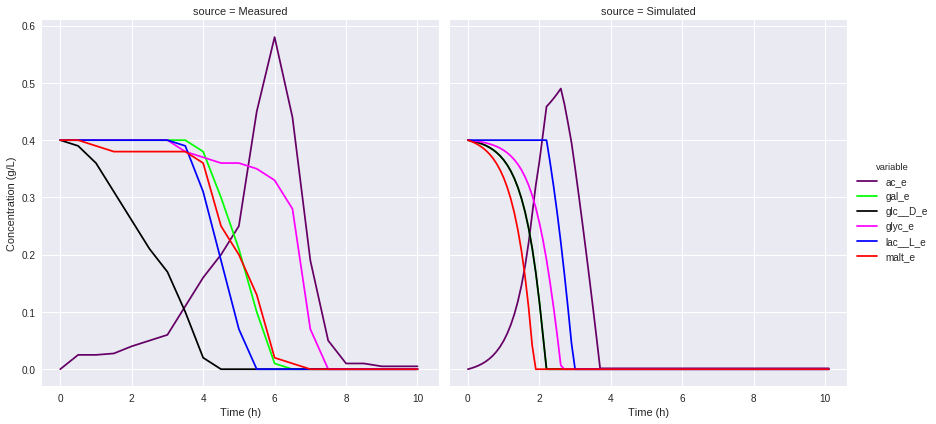

In [20]:
%matplotlib inline
g = plot_dynamic(dsplot_fba, dsplot_meas)
#g.set(ylim=[-0.05, 0.7])

In [21]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/beg_fba_val10.pdf')
# g.savefig('figures/beg_fba_val10.svg')
# g.savefig('figures/beg_fba_val10.eps')
# g.savefig('figures/beg_fba_val10.png',dpi=500)

# 6. Sensitivity of uptake hierarchy to proteome parameters

In [22]:
%%time

N_RAND = 50

import numpy as np

nCrowd = len(pcfba.metabolites.crowding.reactions)
crowding = pcfba.metabolites.crowding
rmin = 0.5
rmax = 2
dfs = []
for _iter in range(N_RAND):
    for rxn in crowding.reactions:
        k0 = coeff_dict[rxn.id]
        r  = np.random.uniform(rmin,rmax)
        rxn._metabolites[crowding] = k0*r

    dfi, df_fluxi = dFBA(pcfba, X0, conc_dict_mol, met_rxn_dict, rxn_mu_id, 10)
    dfi.loc[:,'k'] = _iter    
    dfs.append(dfi)
    
df_rand = pd.concat(dfs)

CPU times: user 1h 3min 21s, sys: 73.4 ms, total: 1h 3min 21s
Wall time: 1h 3min 20s


In [23]:
# Convert to g/L    
df_rand_mass = df_rand.copy()
for col in cols_met:
    mw = model.metabolites.get_by_id(col).formula_weight
    df_rand_mass[col] = df_rand_mass[col] * mw / 1000.
df_rand_mass.rename(columns={'t':'time','X':'biomass'}, inplace=True)    
dsplot_rand = df_rand_mass[['time']+cols_met].melt(id_vars='time')

In [24]:
from matplotlib.patches import Polygon

def plot_ensemble(df_sim, df_meas=None):
    if df_meas is None:
        dsplot = df_sim[ df_sim.variable != 'biomass']
    else:
        df1 = df_meas
        df1.loc[:,'source'] = 'Measured'
        df2 = df_sim
        df2.loc[:,'source'] = 'Simulated'
        dsplot = pd.concat([df1,df2])
    dsplot.loc[:,'variable'] = dsplot.variable.astype('category')
    dsplot.variable.cat.reorder_categories(['ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'], inplace=True)
    sns.set_palette(palette)
    if df_meas is None:
        #g = sns.FacetGrid(dsplot, hue='variable', col='variable', col_wrap=3, size=6)        
        g = sns.FacetGrid(dsplot, hue='variable', size=6)
    else:
        g = sns.FacetGrid(dsplot, hue='variable', col='source', size=6)            
    
    g.map(plt.plot, 'time','value', alpha=0.85, lw=0.25)#, marker='.', markersize=1)
    
    # Plot the mean, too
    df_mean = dsplot.groupby(['time', 'variable']).mean().reset_index()
    df_mean = df_mean.sort_values(['variable','time'])
    levels = ['ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e']
    ax = g.axes.flatten()[0]
    for k,lvl in enumerate(levels):
        dfi = df_mean[df_mean.variable==lvl]
        plt.plot('time','value', data=dfi, color=palette[k], alpha=0.9)
#         dfj = dsplot[dsplot.variable==lvl]
#         dfjmax = dfj.groupby('time').value.max().reset_index()
#         verts = [(row['time'],row['value']) for i,row in dfjmax.sort_values('time').iterrows()]
#         tmin = dfj.time.min()
#         tmax = dfj.time.max()
#         verts = [(tmin,0)] + verts + [(tmax,0)]
#         poly = Polygon(verts, facecolor=palette[k], edgecolor=palette[k], alpha=0.25, zorder=1)
#         ax.add_patch(poly)
    g.set_xlabels('Time (h)')
    g.set_ylabels('Concentration (g/L)')
    g.add_legend()
    
    return g

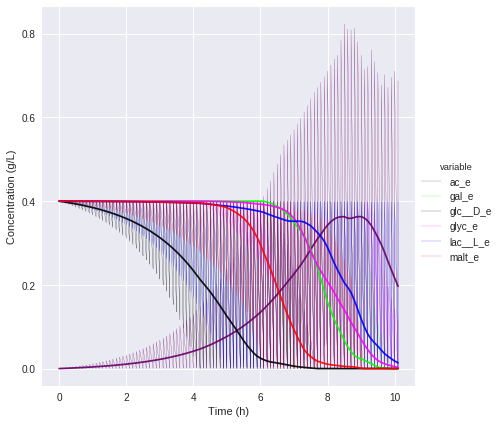

In [25]:
%matplotlib inline
#g = plot_ensemble(dsplot_rand.sort_values('time'))#, dsplot_meas)
#g = plot_ensemble(dsplot_rand)#, dsplot_meas)
g = plot_ensemble(dsplot_rand.sort_values(['variable','time','value']))#, dsplot_meas)
#g.set(ylim=[-0.05, 0.7])

In [26]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/beg_pcfba_rand2.pdf')
# g.savefig('figures/beg_pcfba_rand2.svg')
# g.savefig('figures/beg_pcfba_rand2.eps')
# g.savefig('figures/beg_pcfba_rand2.png',dpi=500)